In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

takeaway_db = '../databases/takeaway.db'
deliveroo_db ='../databases/deliveroo.db'
ubereats_db ='../databases/ubereats.db'

def query_db(db, sql_query):
    ''' input: db (path to SQLite database), sql_query (str)
        output: pandas DataFrame
    '''
    conn = sqlite3.connect(db)
    with conn:
        res = pd.read_sql_query(sql_query, conn)
    if conn:
        conn.close()
    return res

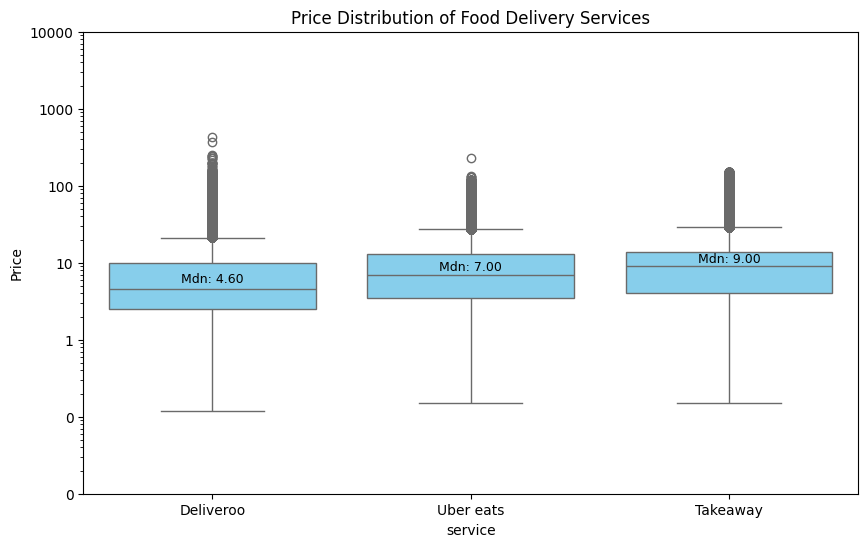

In [31]:
# What is the price distribution of menu items?

## Deliveroo
query1 = """
    SELECT
        CAST(price AS REAL) AS price, name
    FROM
        menu_items
    WHERE
        id NOT IN (1078983574, 297241847, 297241848, 1258473919, 987159854, 1272748371)     --- exclude id's with price in cents
        AND CAST(price AS REAL) > 0.1
    order by price desc
    """

df_deliveroo = query_db(deliveroo_db, query1)
df_deliveroo['service'] = 'Deliveroo'  # Add service column

## Uber Eats
query1 = """
    SELECT
        (price / 100) AS price
    FROM
        menu_items
    WHERE
        price > 10
    """
df_ubereats = query_db(ubereats_db, query1)
df_ubereats['service'] = 'Uber eats'  # Add service column

# Takeaway

query1 = """
    SELECT
        price
    FROM
        menuItems
    WHERE
        price > 0.1
    """
df_takeaway = query_db(takeaway_db, query1)
df_takeaway['service'] = 'Takeaway'  # Add service column


# Combine all the data into a single DataFrame
df_combined = pd.concat([df_deliveroo, df_ubereats, df_takeaway])

# Create boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='service', y='price', data=df_combined, hue='service', palette='Set3', boxprops=dict(facecolor='skyblue'))

# Add the median values as text
median_values = df_combined.groupby('service')['price'].median()
for i, service in enumerate(df_combined['service'].unique()):
    median_value = median_values[service]
    plt.text(i, median_value + 1, f'Mdn: {median_value:.2f}', ha='center', color='black', fontsize=9)

# Customize the plot
plt.title('Price Distribution of Food Delivery Services')
plt.ylabel('Price')
plt.yscale('log')
plt.yticks(ticks=plt.gca().get_yticks(), labels=[f'{int(x)}' for x in plt.gca().get_yticks()])
plt.ylim(bottom=0.01 )

plt.show()


In general prices are not higher than 150 EUR, with the outliers mostly being sushi, wine and combo deals.
For Uber Eats there's one outlier above this level (wine bottle), but for Deliveroo there are many more, mostly being wine bottles.
I suspect much more alcohol is being sold on this last platform since there seems to be no contol on the category it's being put in (for example, wine can be found in 'Dessert', 'Italian', 'Snacks', 'Chicken'... instead of 'Alcohol').

On the bottom side, all platforms have lots of zero-prices used to select options/flavour/extra's, so these were excluded from the boxplots.


In [34]:

query4 = """
    ATTACH DATABASE '../databases/takeaway.db' AS takeaway;
    ATTACH DATABASE '../databases/deliveroo.db' AS deliveroo;
    ATTACH DATABASE '../databases/ubereats.db' AS ubereats;

    SELECT t.name, t.postal_code, d.name, d.postal_code, u.name, u.postal_code
    FROM takeaway.restaurants AS t
    INNER JOIN deliveroo.restaurants AS d
        ON t.name = d.name AND t.postal_code = d.postal_code
    INNER JOIN ubereats.restaurants AS u
        ON t.name = u.name AND t.postal_code = u.postal_code;
"""

query = """
    SELECT
        DISTINCT location__city
    FROM
        restaurants
    where location__city = 'Gent' OR location__city = 'Ghent'
"""

df_ubereats = query_db(ubereats_db, query)

query = """
    SELECT
        city
    FROM
        restaurants
    where city = 'Gent'

"""

df_takeaway = query_db(takeaway_db, query)

query = """
    SELECT
        address
    FROM
        restaurants

"""
df_deliveroo = query_db(deliveroo_db, query)

display(df_deliveroo)

,address
0,523 chaussée de Louvain
1,"Chaussée d'Alsemberg, 916"
2,Rue Basse 9
3,Rue Basse 16
4,Chaussée de Roodebeek 76
...,...
2711,450 Herentalsebaan
2712,2 Vital Decosterstraat
2713,57 Spoorweglaan
2714,14 Gemeentestraat
